In [2]:
from sklearn import metrics, model_selection, ensemble
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import KBinsDiscretizer
import xgboost as xgb
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor
import xgboost
from sklearn.cluster import KMeans


pd.set_option('display.max_columns', None)

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
try: 
    import optuna
except:
    !pip install optuna
    import optuna

In [4]:
try:
    from catboost import Pool, CatBoostRegressor, cv
except:
    !pip install catboost 
    from catboost import Pool, CatBoostRegressor, cv

In [5]:
try:
    from CustomPipeline import *
except:
    import sys
    sys.path.insert(0,'/content/sample_data')
    from CustomPipeline import *
    print("ok")

In [5]:
try:
    train = pd.read_csv("./train_anomaly.csv", delimiter=",", sep='.')
except:
    train = pd.read_csv("./sample_data/train_anomaly.csv", delimiter=",", sep='.')

In [7]:
RANDOM_STATE = 42

In [8]:
train.drop("id", axis=1, inplace=True)
train["target"] = 100 * train["target"]

In [68]:
# test run
# train, test = train_test_split(train, test_size=0.2, random_state=RANDOM_STATE)

In [69]:
train, test_ensemble = train_test_split(train, test_size=0.1, random_state=RANDOM_STATE)
train_estimators, train_ensemble = train_test_split(train, test_size=0.2, random_state=RANDOM_STATE)

In [70]:
X = train_estimators.drop(["target"], axis=1)
y = train_estimators["target"]

In [71]:
num = TypesOfColumns(X).get_num()
cat = TypesOfColumns(X).get_cat()
cat_idx = TypesOfColumns(X).get_cat_idx()

# linear ridge

In [72]:
params_linear = {'alpha': 0.09}
n_bins=63

X_lr = train_estimators.query("target > 600").drop(["target"], axis=1)
y_lr = train_estimators.query("target > 600")["target"]

model = linear_model.Ridge(**params_linear)
lr = LinearWrapper(model, bins_linear=n_bins, cat=cat, num=num)

# xgb

In [77]:
params_xgb = {
    'tree_method':'gpu_hist',
    'random_state': 1, 
    'n_jobs': 4,
    'booster': 'gbtree',
    'n_estimators': 10000,
    'learning_rate': 0.035,
    'reg_lambda': 1.22,
    'reg_alpha': 36.04,
    'subsample': 0.9,
    'colsample_bytree': 0.11,
    'max_depth': 3,
    'min_child_weight': 6
}
model = xgboost.XGBRegressor(**params_xgb)
xgb = XGBWrapper(model, cat=cat, num=num)

# StackingRegressor

In [ ]:
# test = pd.read_csv("./sample_data/test_anomaly.csv", delimiter=",", sep='.')

In [ ]:
models = [lr, xgb]
# models = [catboost]

df_ensemble = pd.DataFrame()
df_test = pd.DataFrame()
df_submit = pd.DataFrame()

for i, model in enumerate(models):
    if model == lr:
        model.train(X_lr, y_lr)
    else:
        model.train(X, y)

    pred = model.predict(train_ensemble.drop(['target'], axis=1))
#     print(pred)
    train_ensemble[str(i)] = pred
    pred = model.predict(test_ensemble.drop(['target'], axis=1))
#     print(pred)
    test_ensemble[str(i)] = pred
    pred = model.predict(test)
#     print(pred)
    test[str(i)] = pred

In [ ]:
# train_ensemble.to_csv('./train_ensemble.csv', index=False)
# test_ensemble.to_csv('./test_ensemble.csv', index=False)
# test.to_csv('./test.csv', index=False)

In [23]:
test_ensemble = pd.read_csv("./en_test_ensemble.csv", delimiter=",", sep='.')
test = pd.read_csv("./en_test_witout_target.csv", delimiter=",", sep='.', index_col='id')
train_ensemble = pd.read_csv("./en_train_ensemble.csv", delimiter=",", sep='.')

In [9]:
test['label'] = 'test'
train_ensemble['label'] = 'train_ensemble'
test_ensemble['label'] = 'test_ensemble'

In [10]:
df = pd.concat([test, train_ensemble.drop('target', axis=1), test_ensemble.drop('target', axis=1)])

In [11]:
df

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,anomaly_col,0,1,label
0,B,B,B,C,B,B,A,E,E,I,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702,Norm,811.794579,802.49600,test
5,A,B,A,C,B,C,A,E,C,H,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940,Norm,841.286617,838.92790,test
15,B,A,A,A,B,B,A,E,D,K,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099,Norm,837.758268,841.12854,test
16,B,B,A,C,B,D,A,E,A,N,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372,Norm,853.769654,847.46990,test
17,B,B,A,C,B,C,A,E,C,F,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412,Norm,819.820749,811.22650,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,B,A,A,C,B,D,A,E,A,F,0.772090,0.299549,0.602349,0.136107,0.321439,0.733027,0.675137,0.433400,0.419443,0.829095,0.749472,0.924683,0.841468,0.155335,Norm,869.400623,867.26910,test_ensemble
29996,A,A,A,C,B,B,A,E,E,B,0.287894,0.495071,0.631200,0.867232,0.283090,0.332150,0.302113,0.515958,0.535950,0.266809,0.052132,0.654320,0.169984,0.322297,Norm,810.539736,808.34860,test_ensemble
29997,A,A,A,C,B,B,A,E,A,G,0.557205,0.428366,0.435169,0.282981,0.275103,0.418939,0.446874,0.817383,0.445138,0.337872,0.229573,0.460156,0.642881,0.708801,Norm,808.015706,809.41300,test_ensemble
29998,A,B,A,C,B,B,A,E,E,O,0.436505,0.132483,0.417743,0.386264,0.871950,0.398272,0.435601,0.504268,0.420534,0.520706,0.228765,0.430401,0.240570,0.823217,Norm,785.915281,782.50354,test_ensemble


In [15]:
X = df
num_train = X.select_dtypes([int, float])
cat_train = X.select_dtypes(object)

num = list(num_train)
cat = list(cat_train)

In [16]:
for i, m in enumerate(num):
    for j, n in enumerate(num):
        if (m != n) and (j > i):
            print(m, n)
            try:
                kmeans = KMeans(n_clusters=9, random_state=0).fit(df[[m, n]])
                df['k_means_' + m + n] = kmeans.labels_
                df['k_means_' + m + n].astype(object)
            except:
                print(m, n, 'problem')


cont0 cont1
cont0 cont2
cont0 cont3
cont0 cont4
cont0 cont5
cont0 cont6
cont0 cont7
cont0 cont8
cont0 cont9
cont0 cont10
cont0 cont11
cont0 cont12
cont0 cont13
cont0 0
cont0 1
cont1 cont2
cont1 cont3
cont1 cont4
cont1 cont5
cont1 cont6
cont1 cont7
cont1 cont8
cont1 cont9
cont1 cont10
cont1 cont11
cont1 cont12
cont1 cont13
cont1 0
cont1 1
cont2 cont3
cont2 cont4
cont2 cont5
cont2 cont6
cont2 cont7
cont2 cont8
cont2 cont9
cont2 cont10
cont2 cont11
cont2 cont12
cont2 cont13
cont2 0
cont2 1
cont3 cont4
cont3 cont5
cont3 cont6
cont3 cont7
cont3 cont8
cont3 cont9
cont3 cont10
cont3 cont11
cont3 cont12
cont3 cont13
cont3 0
cont3 1
cont4 cont5
cont4 cont6
cont4 cont7
cont4 cont8
cont4 cont9
cont4 cont10
cont4 cont11
cont4 cont12
cont4 cont13
cont4 0
cont4 1
cont5 cont6
cont5 cont7
cont5 cont8
cont5 cont9
cont5 cont10
cont5 cont11
cont5 cont12
cont5 cont13
cont5 0
cont5 1
cont6 cont7
cont6 cont8
cont6 cont9
cont6 cont10
cont6 cont11
cont6 cont12
cont6 cont13
cont6 0
cont6 1
cont7 cont8
cont7 co

In [36]:
df['k_means_cont4_cont6_'] = df['cont4'].apply(lambda x: 1 if x<0.1 else 0)
df['k_means_cont4_cont6_'].astype(object)

df['k_means_cont5_cont8_'] = df['cont8'].apply(lambda x: 1 if x<0.1 else 0)
df['k_means_cont5_cont8_'].astype(object)

df['k_means_cont6_cont7_'] = df['cont6'].apply(lambda x: 1 if x<0.1 else 0)
df['k_means_cont6_cont7_'].astype(object)

0        0
5        0
15       0
16       0
17       0
        ..
29995    0
29996    0
29997    0
29998    0
29999    0
Name: k_means_cont6_cont7_, Length: 284000, dtype: object

In [37]:
df.to_csv('./ensemble_with_clusters.csv', index=False)

In [38]:
test_new = df[df['label'] == 'test']
train_ensemble_new = df[df['label'] == 'train_ensemble']
test_ensemble_new = df[df['label'] == 'test_ensemble']

In [39]:
train_ensemble_new

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,anomaly_col,0,1,label,k_means_cont0cont1,k_means_cont0cont2,k_means_cont0cont3,k_means_cont0cont4,k_means_cont0cont5,k_means_cont0cont6,k_means_cont0cont7,k_means_cont0cont8,k_means_cont0cont9,k_means_cont0cont10,k_means_cont0cont11,k_means_cont0cont12,k_means_cont0cont13,k_means_cont00,k_means_cont01,k_means_cont1cont2,k_means_cont1cont3,k_means_cont1cont4,k_means_cont1cont5,k_means_cont1cont6,k_means_cont1cont7,k_means_cont1cont8,k_means_cont1cont9,k_means_cont1cont10,k_means_cont1cont11,k_means_cont1cont12,k_means_cont1cont13,k_means_cont10,k_means_cont11,k_means_cont2cont3,k_means_cont2cont4,k_means_cont2cont5,k_means_cont2cont6,k_means_cont2cont7,k_means_cont2cont8,k_means_cont2cont9,k_means_cont2cont10,k_means_cont2cont11,k_means_cont2cont12,k_means_cont2cont13,k_means_cont20,k_means_cont21,k_means_cont3cont4,k_means_cont3cont5,k_means_cont3cont6,k_means_cont3cont7,k_means_cont3cont8,k_means_cont3cont9,k_means_cont3cont10,k_means_cont3cont11,k_means_cont3cont12,k_means_cont3cont13,k_means_cont30,k_means_cont31,k_means_cont4cont5,k_means_cont4cont6,k_means_cont4cont7,k_means_cont4cont8,k_means_cont4cont9,k_means_cont4cont10,k_means_cont4cont11,k_means_cont4cont12,k_means_cont4cont13,k_means_cont40,k_means_cont41,k_means_cont5cont6,k_means_cont5cont7,k_means_cont5cont8,k_means_cont5cont9,k_means_cont5cont10,k_means_cont5cont11,k_means_cont5cont12,k_means_cont5cont13,k_means_cont50,k_means_cont51,k_means_cont6cont7,k_means_cont6cont8,k_means_cont6cont9,k_means_cont6cont10,k_means_cont6cont11,k_means_cont6cont12,k_means_cont6cont13,k_means_cont60,k_means_cont61,k_means_cont7cont8,k_means_cont7cont9,k_means_cont7cont10,k_means_cont7cont11,k_means_cont7cont12,k_means_cont7cont13,k_means_cont70,k_means_cont71,k_means_cont8cont9,k_means_cont8cont10,k_means_cont8cont11,k_means_cont8cont12,k_means_cont8cont13,k_means_cont80,k_means_cont81,k_means_cont9cont10,k_means_cont9cont11,k_means_cont9cont12,k_means_cont9cont13,k_means_cont90,k_means_cont91,k_means_cont10cont11,k_means_cont10cont12,k_means_cont10cont13,k_means_cont100,k_means_cont101,k_means_cont11cont12,k_means_cont11cont13,k_means_cont110,k_means_cont111,k_means_cont12cont13,k_means_cont120,k_means_cont121,k_means_cont130,k_means_cont131,k_means_01,k_means_cont4_cont6_,k_means_cont5_cont8_,k_means_cont6_cont7_
0,A,A,A,C,B,B,A,E,E,H,0.263894,0.422811,0.455877,0.549582,0.285487,0.565569,-0.141368,0.688337,0.691903,0.439211,0.418874,0.053918,0.198492,0.864552,Norm,822.393348,840.87530,train_ensemble,7,8,8,5,3,7,7,7,7,7,0,4,3,3,6,2,2,2,0,5,7,3,1,6,6,6,3,5,5,1,0,6,6,2,5,5,2,5,0,6,2,6,0,7,4,8,2,0,7,6,6,1,0,7,4,5,3,8,6,1,0,5,0,6,1,1,8,2,6,0,2,8,7,3,1,1,6,6,7,7,5,5,4,1,2,5,8,1,6,8,2,1,3,0,0,1,7,2,7,1,6,3,1,2,1,2,7,7,2,5,4,3,6,1,7,2,1,7,1,8,0,0,1
1,B,B,A,A,C,C,A,E,A,F,0.440252,0.415761,0.546531,0.704333,0.687984,0.158406,0.544799,0.632793,0.316917,0.245392,0.292086,0.583627,0.263786,0.248510,Anomaly,821.181948,802.09760,train_ensemble,0,0,1,8,5,2,3,0,6,0,3,0,6,3,4,1,2,1,5,0,7,0,4,6,7,1,4,5,4,6,1,4,7,6,1,0,2,7,8,4,2,4,1,5,8,2,1,2,5,3,5,6,0,1,5,6,7,2,8,7,4,2,4,6,5,8,1,1,5,8,0,7,0,3,5,0,5,4,3,0,8,3,4,8,1,1,8,7,6,1,2,3,6,7,1,4,1,2,1,5,1,0,0,2,3,1,1,6,2,4,8,2,6,6,2,2,3,7,3,7,0,0,0
2,B,A,A,C,B,B,C,E,C,G,0.556213,0.087407,0.509698,0.549791,0.286923,0.358378,0.465119,0.389759,0.282789,0.392988,0.262058,0.428709,0.353908,0.766063,Anomaly,862.212604,858.83620,train_ensemble,4,0,1,1,7,1,6,0,0,0,8,0,2,4,0,5,5,5,6,7,6,5,6,3,5,7,5,6,0,0,0,0,1,1,1,2,2,1,8,6,3,0,0,0,3,1,1,0,7,7,1,1,8,2,2,4,4,4,6,1,7,1,0,8,6,6,3,8,3,3,5,1,2,4,4,4,7,4,3,4,1,2,8,7,3,4,1,8,3,4,4,8,8,7,5,4,2,3,2,1,5,4,1,3,5,8,1,0,3,0,7,6,5,7,7,3,5,6,8,1,0,0,0
3,A,A,A,C,B,B,A,E,C,A,0.091434,0.317570,1.028451,0.281829,0.699003,0.495328,0.407554,0.203858,0.375169,0.153842,0.315238,0.200414,0.302480,0.299906,Norm,830.719295,813.61000,train_ensemble,7,3,3,0,3,3,5,3,8,7,5,4,5,5,1,8,4,1,2,1,3,0,4,6,6,1,4,3

In [95]:
X

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,anomaly_col,0,1,k_means_cont0cont1,k_means_cont0cont2,k_means_cont0cont3,k_means_cont0cont4,k_means_cont0cont5,k_means_cont0cont6,k_means_cont0cont7,k_means_cont0cont8,k_means_cont0cont9,k_means_cont0cont10,k_means_cont0cont11,k_means_cont0cont12,k_means_cont0cont13,k_means_cont00,k_means_cont01,k_means_cont1cont2,k_means_cont1cont3,k_means_cont1cont4,k_means_cont1cont5,k_means_cont1cont6,k_means_cont1cont7,k_means_cont1cont8,k_means_cont1cont9,k_means_cont1cont10,k_means_cont1cont11,k_means_cont1cont12,k_means_cont1cont13,k_means_cont10,k_means_cont11,k_means_cont2cont3,k_means_cont2cont4,k_means_cont2cont5,k_means_cont2cont6,k_means_cont2cont7,k_means_cont2cont8,k_means_cont2cont9,k_means_cont2cont10,k_means_cont2cont11,k_means_cont2cont12,k_means_cont2cont13,k_means_cont20,k_means_cont21,k_means_cont3cont4,k_means_cont3cont5,k_means_cont3cont6,k_means_cont3cont7,k_means_cont3cont8,k_means_cont3cont9,k_means_cont3cont10,k_means_cont3cont11,k_means_cont3cont12,k_means_cont3cont13,k_means_cont30,k_means_cont31,k_means_cont4cont5,k_means_cont4cont6,k_means_cont4cont7,k_means_cont4cont8,k_means_cont4cont9,k_means_cont4cont10,k_means_cont4cont11,k_means_cont4cont12,k_means_cont4cont13,k_means_cont40,k_means_cont41,k_means_cont5cont6,k_means_cont5cont7,k_means_cont5cont8,k_means_cont5cont9,k_means_cont5cont10,k_means_cont5cont11,k_means_cont5cont12,k_means_cont5cont13,k_means_cont50,k_means_cont51,k_means_cont6cont7,k_means_cont6cont8,k_means_cont6cont9,k_means_cont6cont10,k_means_cont6cont11,k_means_cont6cont12,k_means_cont6cont13,k_means_cont60,k_means_cont61,k_means_cont7cont8,k_means_cont7cont9,k_means_cont7cont10,k_means_cont7cont11,k_means_cont7cont12,k_means_cont7cont13,k_means_cont70,k_means_cont71,k_means_cont8cont9,k_means_cont8cont10,k_means_cont8cont11,k_means_cont8cont12,k_means_cont8cont13,k_means_cont80,k_means_cont81,k_means_cont9cont10,k_means_cont9cont11,k_means_cont9cont12,k_means_cont9cont13,k_means_cont90,k_means_cont91,k_means_cont10cont11,k_means_cont10cont12,k_means_cont10cont13,k_means_cont100,k_means_cont101,k_means_cont11cont12,k_means_cont11cont13,k_means_cont110,k_means_cont111,k_means_cont12cont13,k_means_cont120,k_means_cont121,k_means_cont130,k_means_cont131,k_means_01,k_means_cont4_cont6_,k_means_cont5_cont8_,k_means_cont6_cont7_
0,A,A,A,C,B,B,A,E,E,H,0.263894,0.422811,0.455877,0.549582,0.285487,0.565569,-0.141368,0.688337,0.691903,0.439211,0.418874,0.053918,0.198492,0.864552,Norm,822.393348,840.87530,7,8,8,5,3,7,7,7,7,7,0,4,3,3,6,2,2,2,0,5,7,3,1,6,6,6,3,5,5,1,0,6,6,2,5,5,2,5,0,6,2,6,0,7,4,8,2,0,7,6,6,1,0,7,4,5,3,8,6,1,0,5,0,6,1,1,8,2,6,0,2,8,7,3,1,1,6,6,7,7,5,5,4,1,2,5,8,1,6,8,2,1,3,0,0,1,7,2,7,1,6,3,1,2,1,2,7,7,2,5,4,3,6,1,7,2,1,7,1,8,0,0,1
1,B,B,A,A,C,C,A,E,A,F,0.440252,0.415761,0.546531,0.704333,0.687984,0.158406,0.544799,0.632793,0.316917,0.245392,0.292086,0.583627,0.263786,0.248510,Anomaly,821.181948,802.09760,0,0,1,8,5,2,3,0,6,0,3,0,6,3,4,1,2,1,5,0,7,0,4,6,7,1,4,5,4,6,1,4,7,6,1,0,2,7,8,4,2,4,1,5,8,2,1,2,5,3,5,6,0,1,5,6,7,2,8,7,4,2,4,6,5,8,1,1,5,8,0,7,0,3,5,0,5,4,3,0,8,3,4,8,1,1,8,7,6,1,2,3,6,7,1,4,1,2,1,5,1,0,0,2,3,1,1,6,2,4,8,2,6,6,2,2,3,7,3,7,0,0,0
2,B,A,A,C,B,B,C,E,C,G,0.556213,0.087407,0.509698,0.549791,0.286923,0.358378,0.465119,0.389759,0.282789,0.392988,0.262058,0.428709,0.353908,0.766063,Anomaly,862.212604,858.83620,4,0,1,1,7,1,6,0,0,0,8,0,2,4,0,5,5,5,6,7,6,5,6,3,5,7,5,6,0,0,0,0,1,1,1,2,2,1,8,6,3,0,0,0,3,1,1,0,7,7,1,1,8,2,2,4,4,4,6,1,7,1,0,8,6,6,3,8,3,3,5,1,2,4,4,4,7,4,3,4,1,2,8,7,3,4,1,8,3,4,4,8,8,7,5,4,2,3,2,1,5,4,1,3,5,8,1,0,3,0,7,6,5,7,7,3,5,6,8,1,0,0,0
3,A,A,A,C,B,B,A,E,C,A,0.091434,0.317570,1.028451,0.281829,0.699003,0.495328,0.407554,0.203858,0.375169,0.153842,0.315238,0.200414,0.302480,0.299906,Norm,830.719295,813.61000,7,3,3,0,3,3,5,3,8,7,5,4,5,5,1,8,4,1,2,1,3,0,4,6,6,1,4,3,1,3,8,2,3,5,2,3,1,3,6,7,6,1,2,3,0,5,8,3,3,6,7,3,5,4,3,1,1,2,8,7,5

In [96]:
X = train_ensemble_new.drop('label', axis=1)
y = train_ensemble['target']

num_train = X.select_dtypes([int, float])
cat_train = X.select_dtypes(object)

num = list(num_train)
cat = list(cat_train)

rmse = make_scorer(mean_squared_error, squared=False)

pipeline_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaling', StandardScaler()),  
    ('normal', PowerTransformer())
])
pipeline_cat = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('encoding', OrdinalEncoder()),
    ('encoding', OneHotEncoder(handle_unknown='ignore')),
])
preprocessor = ColumnTransformer(n_jobs=-1,
    transformers=[
        ('num', pipeline_num, num),
        ('cat', pipeline_cat, cat),
        ], remainder="passthrough")

preprocessor.fit(df.drop('label', axis=1))
transform = preprocessor.transform(X)
X_test_ensemble = preprocessor.transform(test_ensemble_new.drop('label', axis=1))
X_test = preprocessor.transform(test_new.drop('label', axis=1))

In [97]:
def objective(trial):
    
    param_model = {
        'alpha': trial.suggest_loguniform('alpha', 1e-2, 1.0),
        'random_state':trial.suggest_categorical("random_state", [0, 42]),
    }
    
    pipeline_ridge = Pipeline(steps=[ 
                                     ('model', linear_model.Lasso(**param_model)),
                                     ])

    rmse_mean_cv = cross_val_score(pipeline_ridge, transform, y, cv=5, scoring=rmse)
    print(rmse_mean_cv)

    return rmse_mean_cv.mean()

In [98]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=10)
# 72.05929420329886.
# 72.05702112640415.

[I 2021-08-30 19:22:58,314] A new study created in memory with name: no-name-14ada3ec-a774-44bf-ad8a-dcc5330b632a
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76459.19122964144, tolerance: 24412.796234169222
  positive)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80378.74844616652, tolerance: 24358.99688065945
  positive)
[I 2021-08-30 19:24:44,338] Trial 0 finished with value: 72.11069705914039 and parameters: {'alpha': 0.0257294744181235, 'random_state': 0}. Best is trial 0 with value: 72.11069705914039.


[72.36055594 72.28142032 71.75442738 71.89833731 72.25874434]


[I 2021-08-30 19:24:55,263] Trial 1 finished with value: 72.08951005080758 and parameters: {'alpha': 0.05682225491783954, 'random_state': 42}. Best is trial 1 with value: 72.08951005080758.


[72.35135171 72.24954751 71.73066623 71.88317285 72.23281195]


[I 2021-08-30 19:25:00,889] Trial 2 finished with value: 72.06176413061769 and parameters: {'alpha': 0.12452418552354243, 'random_state': 0}. Best is trial 2 with value: 72.06176413061769.


[72.32929245 72.21126431 71.70343145 71.86110213 72.20373032]


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112244.84268194437, tolerance: 24226.26554688837
  positive)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99880.8724501133, tolerance: 24412.796234169222
  positive)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105094.60566785932, tolerance: 24358.99688065945
  positive)
[I 2021-08-30 19:27:16,066] Trial 3 finished with value: 72.11369776604177 and parameters: {'alpha': 0.0222596803062459, 'random_state': 0}. Best is 

[72.36026477 72.28632891 71.75976374 71.9001688  72.26196262]


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185938.63656541705, tolerance: 24226.26554688837
  positive)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163623.4410571754, tolerance: 24412.796234169222
  positive)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172303.22519141436, tolerance: 24358.99688065945
  positive)
[I 2021-08-30 19:29:42,649] Trial 4 finished with value: 72.11846914701175 and parameters: {'alpha': 0.017050160600532004, 'random_state': 0}. Best 

[72.36013695 72.29386484 71.768306   71.9026746  72.26736335]


[I 2021-08-30 19:29:52,488] Trial 5 finished with value: 72.08436680574054 and parameters: {'alpha': 0.0666776800364425, 'random_state': 42}. Best is trial 2 with value: 72.06176413061769.


[72.34825789 72.24184218 71.72549695 71.87916389 72.22707311]


[I 2021-08-30 19:29:57,717] Trial 6 finished with value: 72.05055230225048 and parameters: {'alpha': 0.17072833827712106, 'random_state': 0}. Best is trial 6 with value: 72.05055230225048.


[72.31992072 72.19640532 71.68845642 71.8546014  72.19337764]


[I 2021-08-30 19:30:03,218] Trial 7 finished with value: 72.06352169483075 and parameters: {'alpha': 0.11874635313690139, 'random_state': 42}. Best is trial 6 with value: 72.05055230225048.


[72.33087346 72.21336938 71.70569094 71.86243499 72.20523969]


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275491.197468251, tolerance: 24226.26554688837
  positive)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240343.25551503897, tolerance: 24412.796234169222
  positive)
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253305.43833500147, tolerance: 24358.99688065945
  positive)
[I 2021-08-30 19:32:31,539] Trial 8 finished with value: 72.12257213780637 and parameters: {'alpha': 0.013847568212524423, 'random_state': 42}. Best 

[72.36253025 72.29825404 71.77586117 71.90508116 72.27113407]


[I 2021-08-30 19:32:36,079] Trial 9 finished with value: 72.03808063078989 and parameters: {'alpha': 0.3148000231426596, 'random_state': 0}. Best is trial 9 with value: 72.03808063078989.


[72.30390221 72.18939011 71.6659926  71.85559902 72.17551922]


In [100]:
best_params = study.best_trial.params
best_params 

{'alpha': 0.3148000231426596, 'random_state': 0}

# check bias clusters

In [101]:
from sklearn.linear_model import Lasso
model = Lasso(**best_params)
model.fit(transform, y)

Lasso(alpha=0.3148000231426596, random_state=0)

In [ ]:
pred = model.predict(transform)
print(mean_squared_error(train_ensemble["target"], pred, squared=False))
train_ensemble['pred_lasso'] = pred

In [102]:
pred = model.predict(X_test_ensemble)
print(mean_squared_error(test_ensemble["target"], pred, squared=False))

71.80006994417889


In [107]:
pred = model.predict(X_test)
test['target'] = pred / 100

In [104]:
train_ensemble

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target,anomaly_col,0,1,pred_lasso,residuals,label
0,A,A,A,C,B,B,A,E,E,H,0.263894,0.422811,0.455877,0.549582,0.285487,0.565569,-0.141368,0.688337,0.691903,0.439211,0.418874,0.053918,0.198492,0.864552,719.973554,Norm,822.393348,840.87530,835.232039,-102.419793,1
1,B,B,A,A,C,C,A,E,A,F,0.440252,0.415761,0.546531,0.704333,0.687984,0.158406,0.544799,0.632793,0.316917,0.245392,0.292086,0.583627,0.263786,0.248510,813.072326,Anomaly,821.181948,802.09760,807.228011,-8.109623,1
2,B,A,A,C,B,B,C,E,C,G,0.556213,0.087407,0.509698,0.549791,0.286923,0.358378,0.465119,0.389759,0.282789,0.392988,0.262058,0.428709,0.353908,0.766063,953.767401,Anomaly,862.212604,858.83620,858.638073,91.554797,1
3,A,A,A,C,B,B,A,E,C,A,0.091434,0.317570,1.028451,0.281829,0.699003,0.495328,0.407554,0.203858,0.375169,0.153842,0.315238,0.200414,0.302480,0.299906,766.967046,Norm,830.719295,813.61000,818.639133,-63.752249,1
4,A,B,A,C,B,D,A,E,A,I,0.621734,0.816455,0.297241,0.536833,0.524217,0.803557,0.150297,0.607898,0.259313,0.275478,0.507401,0.845441,0.783878,0.169852,816.300457,Norm,813.834500,805.53284,807.631218,2.465957,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53995,A,B,A,C,B,B,A,E,C,F,0.713022,0.251317,0.612808,0.721725,0.342860,0.819535,0.881754,0.472204,0.412661,0.558916,0.454587,0.340566,0.397448,0.287042,874.369410,Norm,838.510350,844.04315,842.697619,35.859060,1
53996,B,B,A,C,B,B,A,B,A,G,0.437447,0.234785,0.505016,0.539729,0.286069,0.300176,0.553383,0.559673,0.839478,0.827247,0.276473,0.754376,0.284526,0.523540,826.677350,Anomaly,809.192132,807.62120,807.251723,17.485219,1
53997,A,B,A,C,B,B,A,E,C,I,0.217517,0.764528,0.323548,0.465224,0.531727,0.462099,0.383066,0.350403,0.375989,0.315024,0.080939,0.371964,0.591805,0.683887,705.166978,Norm,795.673766,803.96590,800.487396,-90.506788,1
53998,B,B,A,C,B,B,A,E,E,I,0.382687,0.772405,0.676804,0.367690,0.569831,0.422857,0.426998,0.499143,0.325629,0.365058,0.050370,0.052908,0.173300,0.587090,818.386556,Norm,783.106832,750.08276,759.633866,35.279724,1


In [63]:
train_ensemble['residuals'] = train_ensemble['target'] - train_ensemble['0']
train_ensemble['label'] = train_ensemble.residuals.apply(lambda x: 1 if x > -180 else 0) 

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='0'>

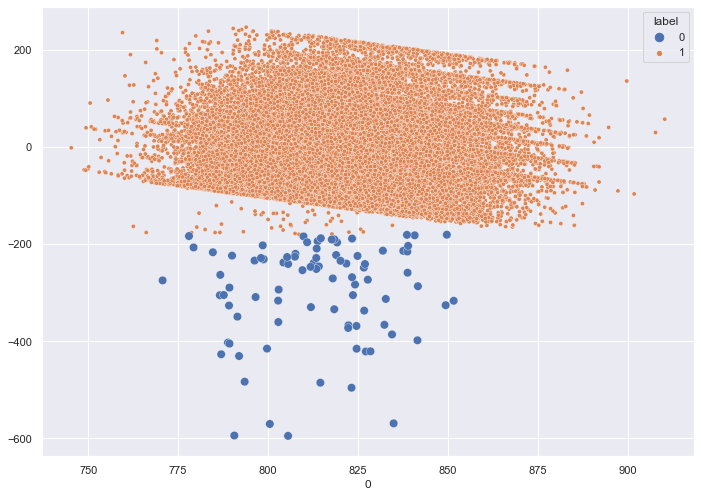

In [65]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
residuals = train_ensemble['target'] - train_ensemble['0']
sns.scatterplot(train_ensemble['0'], residuals, hue = train_ensemble['label'], size=train_ensemble['label'])

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='pred_lasso'>

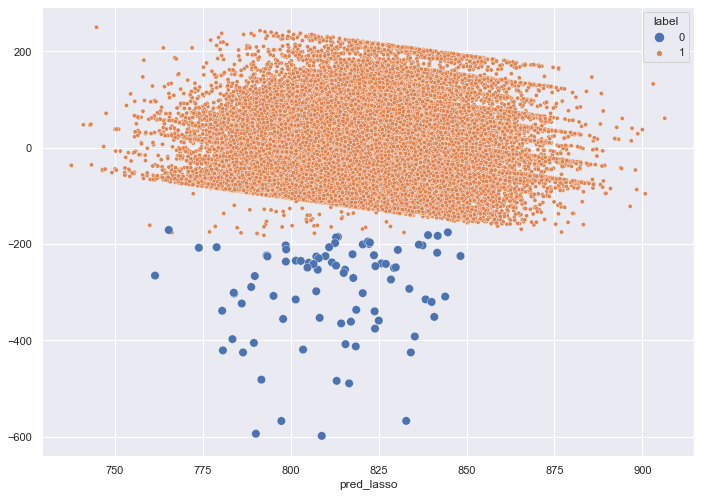

In [66]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
residuals = train_ensemble['target'] - train_ensemble['pred_lasso']
sns.scatterplot(train_ensemble['pred_lasso'], residuals, hue = train_ensemble['label'], size=train_ensemble['label'])

In [67]:
# for i, m in enumerate(num):
#     for j, n in enumerate(num):
#         if (m != n) and (j > i):
#             plt.figure()
#             sns.scatterplot(train_ensemble[m], train_ensemble[n], hue = train_ensemble['label'], size=train_ensemble['label'])

# save predict

In [ ]:
# test = pd.read_csv("./sample_data/test_anomaly.csv", delimiter=",", sep='.')

In [ ]:
# df_ensemble = pd.DataFrame()
# df_ensemble['lr'] = lr_pred
# df_ensemble['xgb_pred'] = xgb_pred
# df_ensemble['cat_pred'] = cat_pred

# df_test = pd.DataFrame()
# df_test['lr'] = lr_test
# df_test['xgb_pred'] = xgb_test
# df_test['cat_pred'] = cat_test

In [ ]:
# # del
# lr_pred1 = lr.predict(test)
# xgb_pred1 = xgb.predict(test)
# cat_pred1 = catboost.predict(test)

# df_submit = pd.DataFrame()
# df_submit['lr'] = lr_pred1
# df_submit['xgb_pred'] = xgb_pred1
# df_submit['cat_pred'] = cat_pred1

In [24]:
# pred = pipeline_ridge.predict(test)

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [108]:
test.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,anomaly_col,0,1,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,B,B,B,C,B,B,A,E,E,I,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702,Norm,811.794579,802.49600,8.054106
5,A,B,A,C,B,C,A,E,C,H,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940,Norm,841.286617,838.92790,8.398491
15,B,A,A,A,B,B,A,E,D,K,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099,Norm,837.758268,841.12854,8.426054
16,B,B,A,C,B,D,A,E,A,N,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372,Norm,853.769654,847.46990,8.509720
17,B,B,A,C,B,C,A,E,C,F,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412,Norm,819.820749,811.22650,8.131792


In [109]:
test[['target']].to_csv('./ensemble_for_submit_with_clusters.csv', index=True)